In [129]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [292]:
os.listdir('./dataset2')

['normal', 'osteoporosis']

In [293]:
dataset_path = './dataset2'

In [294]:
training_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [295]:
full_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = training_transforms)

In [296]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

print(len(full_dataset), train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

744 595 149


In [297]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = False)

In [137]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    
    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [10]:
mean, std = get_mean_and_std(train_loader)

Data Augmentation

In [298]:
train_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.RandomHorizontalFlip(), # Randomise direction of image,
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95,1.05)), 
    transforms.ToTensor(), # Multidimensional array,
    transforms.Normalize(mean,std)
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.ToTensor(), # Multidimensional array,
    transforms.Normalize(mean,std)
])

In [299]:
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

In [13]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([0, 1, 1, 1, 0, 1])


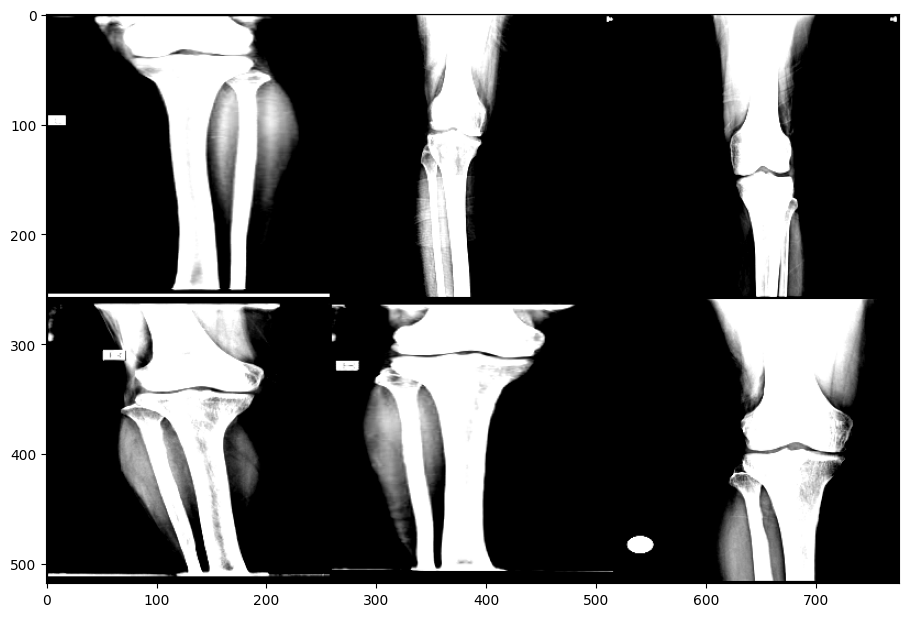

In [86]:
show_transformed_images(train_dataset)

In [87]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle=False)

In [140]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

Iterative Model Training

In [89]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, checkpoint=True):
    device = set_device()

    epoch_acc_list = []
    best_acc = 0

    for epoch in range(n_epochs):
        print(f'Epoch number {epoch + 1}')
        model.train() # Set train mode
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            # Reset optimizer parameters to 0
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward() # Back propagate to calculate weight gradient

            optimizer.step() # Update Weights
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print('     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f' 
              % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
    
        epoch_acc_list.append(test_dataset_acc)

        if (test_dataset_acc > best_acc) and test_dataset_acc < 100:
            best_acc = test_dataset_acc
            if checkpoint:
                save_checkpoint(model, epoch, optimizer, best_acc)
        
        cutoff = False
        if cutoff:
            if len(epoch_acc_list) >= 3:
                if epoch_acc_list[-1] == epoch_acc_list[-2] == epoch_acc_list[-3] and epoch_acc_list[-1] > 0:
                    print('Finished')
                    return best_acc, epoch_acc_list
    print('Finished')
    return best_acc, epoch_acc_list

In [90]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch+1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'description': 'Efficientnet Optimised Model'
    }

    torch.save(state, 'model_best_checkpoint.pth.tar')

In [139]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.0* predicted_correctly_on_epoch / total

    print('     - Testing dataset. Got %d out of %d images correctly (%.3f%%)' 
          % (predicted_correctly_on_epoch, total, epoch_acc))
    
    return epoch_acc

In [92]:
def cross_validation(full_dataset, train_transforms, test_transforms, k_fold=5):
    accuracy_history = pd.DataFrame()
    best_accuracies = []
    total_size = len(full_dataset)
    fraction = 1/k_fold
    seg = int(total_size*fraction)

    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size

        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))

        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
    
        train_set = torch.utils.data.dataset.Subset(full_dataset,train_indices)
        test_set = torch.utils.data.dataset.Subset(full_dataset,val_indices)
    
        train_set.dataset.transform = train_transforms
        test_set.dataset.transform = test_transforms
    
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)
        
        

        efficientnet_model = models.efficientnet_b0(pretrained=False)
        #num_ftrs = efficientnet_model.fc.in_features
        num_classes = 2
        efficientnet_model.fc = nn.Linear(1280, num_classes)
        device = set_device()
        efficientnet_model = efficientnet_model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.002, momentum=0.3, weight_decay=0.03)
        best_acc, epoch_acc_list = train_nn(efficientnet_model, train_loader, test_loader, criterion, optimizer, 150, False)
        print(f'k_fold_{i+1} Completed')
        accuracy_history[f'k_fold_{i+1}'] = epoch_acc_list
        best_accuracies.append(best_acc)
    
    return best_accuracies, accuracy_history


Cross Validation (k-fold = 5)

In [300]:
best_accuracies, accuracy_history = cross_validation(full_dataset, train_transforms, test_transforms)

NameError: name 'cross_validation' is not defined

In [ ]:
accuracy_history.index += 1

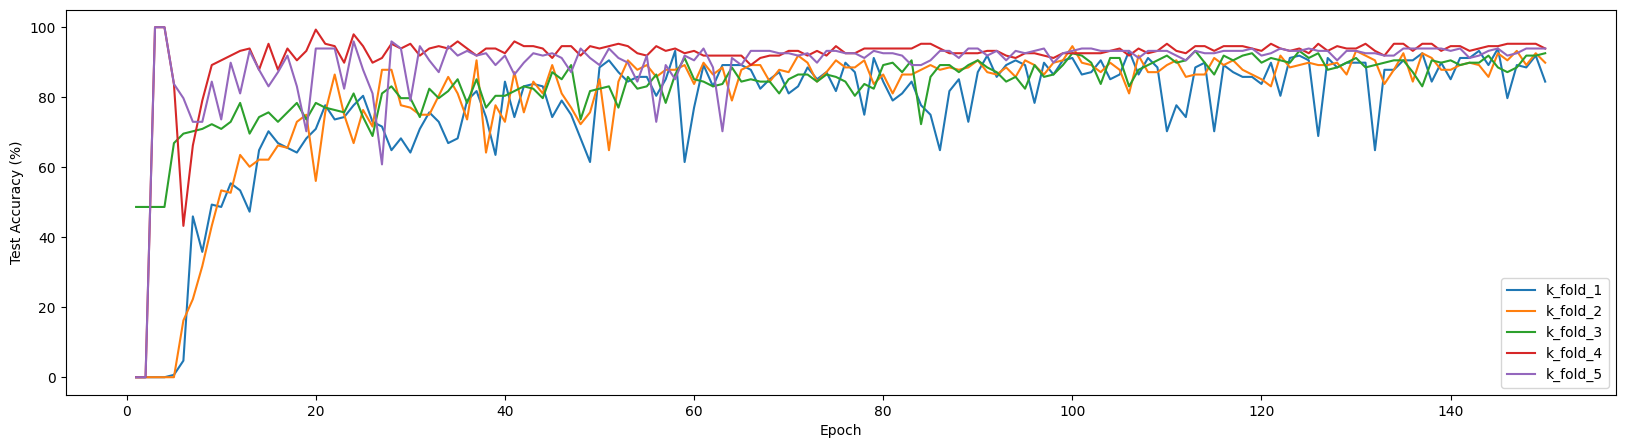

[93.91891892 94.59459459 93.24324324 99.32432432 95.94594595]
      k_fold_1   k_fold_2   k_fold_3    k_fold_4    k_fold_5
1     0.000000   0.000000  48.648649    0.000000    0.000000
2     0.000000   0.000000  48.648649    0.000000    0.000000
3     0.000000   0.000000  48.648649  100.000000  100.000000
4     0.000000   0.000000  48.648649  100.000000  100.000000
5     0.675676   0.000000  66.891892   83.783784   83.783784
..         ...        ...        ...         ...         ...
146  79.729730  90.540541  87.162162   95.270270   91.891892
147  89.189189  93.243243  88.513514   95.270270   92.567568
148  88.513514  89.189189  91.891892   95.270270   93.918919
149  91.891892  92.567568  91.891892   95.270270   93.918919
150  84.459459  89.864865  92.567568   93.918919   93.918919

[150 rows x 5 columns]
Mean Best Accuracy: 95.405%


In [ ]:
accuracy_history.plot(figsize=(20,5))
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.show()

best_accuracies = np.array(best_accuracies)
print(best_accuracies)
print(accuracy_history)
print('Mean Best Accuracy: %.3f%%' %(best_accuracies.mean()))

Generate Optimized Model

In [ ]:
efficientnet_model = models.efficientnet_b0(pretrained=False)
#num_ftrs = efficientnet_model.fc.in_features
num_classes = 2
efficientnet_model.fc = nn.Linear(1280, num_classes)
device = set_device()
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.002, momentum=0.3, weight_decay=0.03)
best_acc, epoch_acc_list = train_nn(efficientnet_model, train_loader, test_loader, criterion, optimizer, 150)

Epoch number 1


c:\Users\NEO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NEO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


     - Training dataset. Got 144 out of 595 images correctly (24.202%). Epoch loss: 6.522
     - Testing dataset. Got 0 out of 149 images correctly (0.000%)
Epoch number 2
     - Training dataset. Got 351 out of 595 images correctly (58.992%). Epoch loss: 5.484
     - Testing dataset. Got 78 out of 149 images correctly (52.349%)
Epoch number 3
     - Training dataset. Got 361 out of 595 images correctly (60.672%). Epoch loss: 4.471
     - Testing dataset. Got 78 out of 149 images correctly (52.349%)
Epoch number 4
     - Training dataset. Got 368 out of 595 images correctly (61.849%). Epoch loss: 3.451
     - Testing dataset. Got 78 out of 149 images correctly (52.349%)
Epoch number 5
     - Training dataset. Got 364 out of 595 images correctly (61.176%). Epoch loss: 2.574
     - Testing dataset. Got 79 out of 149 images correctly (53.020%)
Epoch number 6
     - Training dataset. Got 384 out of 595 images correctly (64.538%). Epoch loss: 1.849
     - Testing dataset. Got 114 out of 149

In [141]:
plt.figure(figsize=(20,5))
plt.plot(list(range(1, len(epoch_acc_list)+1)), epoch_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.show()

print('Best Accuracy: %.3f%%' %(best_acc))

NameError: name 'epoch_acc_list' is not defined

<Figure size 2000x500 with 0 Axes>

In [365]:
checkpoint = torch.load('model_best_checkpoint (89.2%).pth.tar')
efficientnet_model = models.efficientnet_b0(pretrained=False)
num_classes = 2
efficientnet_model.fc = nn.Linear(1280, num_classes)
efficientnet_model.load_state_dict(checkpoint['model'])
#torch.save(efficientnet_model, 'best_model.pth')

c:\Users\NEO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NEO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [366]:
print(f'Optimised Model Accuracy: {round(checkpoint['best_accuracy'],3)}%')

Optimised Model Accuracy: 89.262%


In [387]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
def model_diagnostics(model, loader):
    
    # Lists to store predictions and ground truth labels
    predictions = []
    ground_truth = []

    # Iterate over the dataset and collect predictions and ground truth labels
    model.eval()
    total = 0
    device = 'cpu'
    model = model.to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(probabilities.numpy()[:, 1])  # Assuming binary classification (class index 1)
            ground_truth.extend(labels.numpy())



    # Confusion Matrix
    confusion_mat = confusion_matrix(np.array(ground_truth), (np.array(predictions) >= 0.5))

    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision
    precision = confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[0][1])*100
    print(f'Precision: {precision}%')

    # Recall
    recall = confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[1][0])*100
    print(f'Recall: {recall}%')



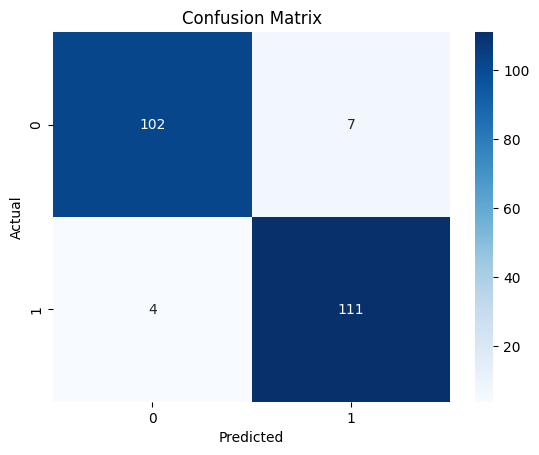

Precision: 93.57798165137615%
Recall: 96.22641509433963%


In [388]:
model_diagnostics(efficientnet_model, test_loader)

Single Image Classifier

In [381]:
import PIL.Image as Image
import cv2
from torchcam.methods import SmoothGradCAMpp, SSCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from matplotlib.animation import FuncAnimation

def classify(model, image_transforms, image_path, classes):
    device = 'cpu'
    mode = model.to(device)
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)


    output = model(image)
    _, predicted = torch.max(output.data, 1)

    probs = torch.nn.functional.softmax(output, dim=1)
    conf, sep = torch.max(probs, 1)
    conf = round(float(conf[0])*100, 3)
    print(f'Prediction: {classes[predicted.item()]} ({conf}%)')

    process_gradcam(model, image_transforms, image_path)


def process_gradcam(model, image_transforms, image_path):
    device = 'cpu'
    mode = model.to(device)
    model = model.eval()

    image = Image.open(image_path)
    input_tensor = image_transforms(image)
    transform = transforms.ToTensor()
    output_tensor = transform(image)



    with SmoothGradCAMpp(model) as cam_extractor:
        # Preprocess your data and feed it to the model
        out = model(input_tensor.unsqueeze(0))
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)



    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(output_tensor), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

    # Display it


    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()





Prediction: Normal (98.199%)


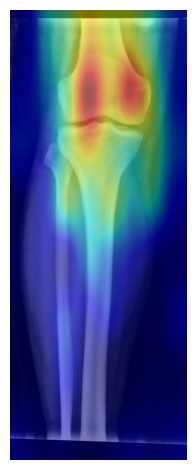

Prediction: Osteoporosis (99.161%)


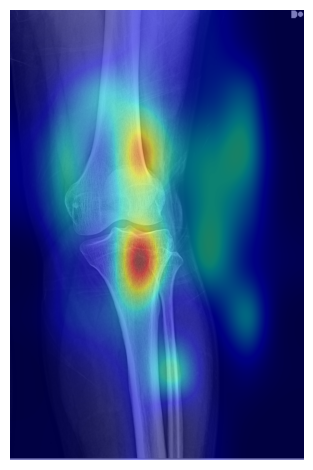

In [386]:
classes = ['Normal', 'Osteoporosis']
classify(efficientnet_model, test_transforms, 'normal_example.jpg', classes)
classify(efficientnet_model, test_transforms, '226.png', classes)


External Validation

In [359]:
transfer_dataset = torchvision.datasets.ImageFolder(root = transfer_dataset_path, transform = test_transforms)


In [ ]:
def split_double_knee(image_directory):

    image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.JPEG', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        image = Image.open(image_path)
        
        width, height = image.size
        half_width = width // 2
        left_half = image.crop((0, 0, half_width, height))
        right_half = image.crop((half_width, 0, width, height))
        
        left_half.save(os.path.join(image_directory, f"left_{image_file}"))
        right_half.save(os.path.join(image_directory, f"right_{image_file}"))

744 520 224
labels:  tensor([0, 1, 1, 0, 1, 0])


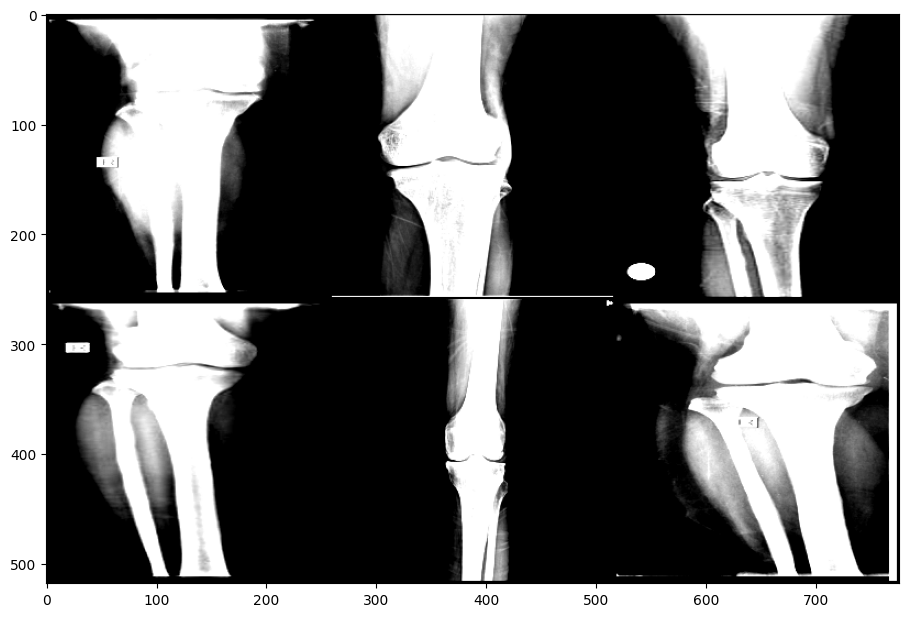

In [360]:
train_size = int(0.7 * len(transfer_dataset))
test_size = len(transfer_dataset) - train_size

print(len(transfer_dataset), train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(transfer_dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

show_transformed_images(train_dataset)

In [361]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 8, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 8, shuffle=False)
transfer_loader = torch.utils.data.DataLoader(dataset = transfer_dataset, batch_size = 8, shuffle=False)

In [362]:
device = set_device()
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.0002, momentum=0.3, weight_decay=0.03)
external_val_dataset_acc = evaluate_model_on_test_set(efficientnet_model, transfer_loader)

     - Testing dataset. Got 715 out of 744 images correctly (96.102%)


In [363]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
def model_diagnostics(model, loader):
    
    # Lists to store predictions and ground truth labels
    predictions = []
    ground_truth = []

    # Iterate over the dataset and collect predictions and ground truth labels
    model.eval()
    total = 0
    device = 'cpu'
    model = model.to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(probabilities.numpy()[:, 1])  # Assuming binary classification (class index 1)
            ground_truth.extend(labels.numpy())



    # Confusion Matrix
    confusion_mat = confusion_matrix(np.array(ground_truth), (np.array(predictions) >= 0.5))

    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision
    precision = confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[0][1])*100
    print(f'Precision: {precision}%')

    # Recall
    recall = confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[1][0])*100
    print(f'Recall: {recall}%')


    # Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(np.array(ground_truth), (np.array(predictions) >= 0.5))

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    # Convert predictions and ground truth labels to tensors
    predictions = torch.tensor(predictions)
    ground_truth = torch.tensor(ground_truth)

    # Sort the predictions and ground truth labels by prediction scores
    sorted_indices = torch.argsort(predictions)
    sorted_predictions = predictions[sorted_indices]
    sorted_ground_truth = ground_truth[sorted_indices]

    # Compute accuracy at each threshold
    thresholds = torch.linspace(0, 1, 100)  # Thresholds for classifying predictions
    accuracies = []

    for threshold in thresholds:
        # Classify predictions based on the threshold
        classified_predictions = (sorted_predictions >= threshold).float()

        # Compute accuracy
        if len(classified_predictions) > 0:
            accuracy = torch.mean((classified_predictions == sorted_ground_truth).float())
            accuracies.append(accuracy.item())
        else:
            accuracies.append(0)

    # Plot the confidence vs. accuracy curve
    plt.plot(accuracies, thresholds.numpy())
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.ylabel('Confidence Threshold')
    plt.xlabel('Accuracy')
    plt.title('Confidence vs. Accuracy')
    plt.show()
    

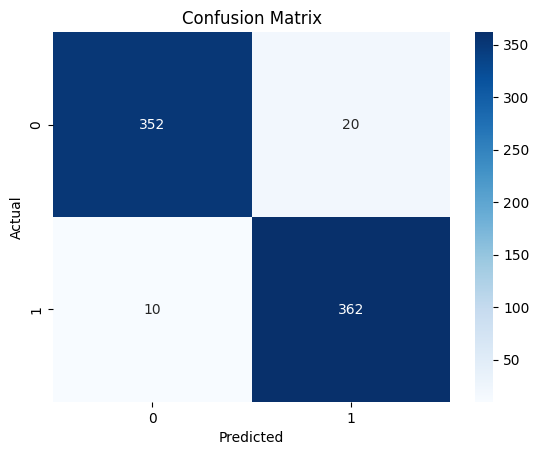

Precision: 94.6236559139785%
Recall: 97.23756906077348%


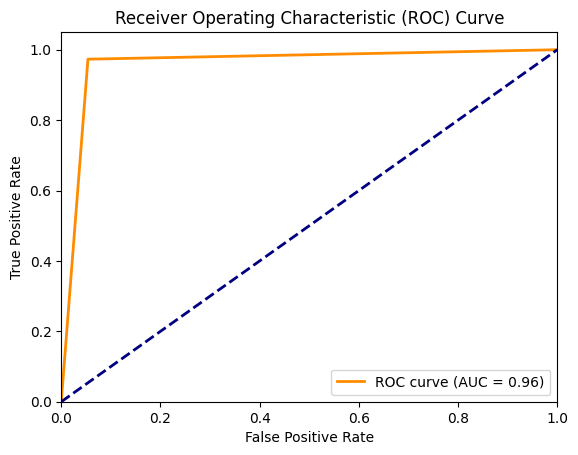

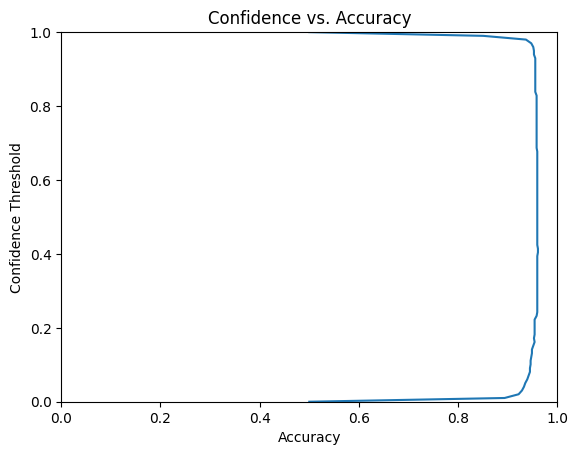

In [364]:
model_diagnostics(efficientnet_model, full_loader)